In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

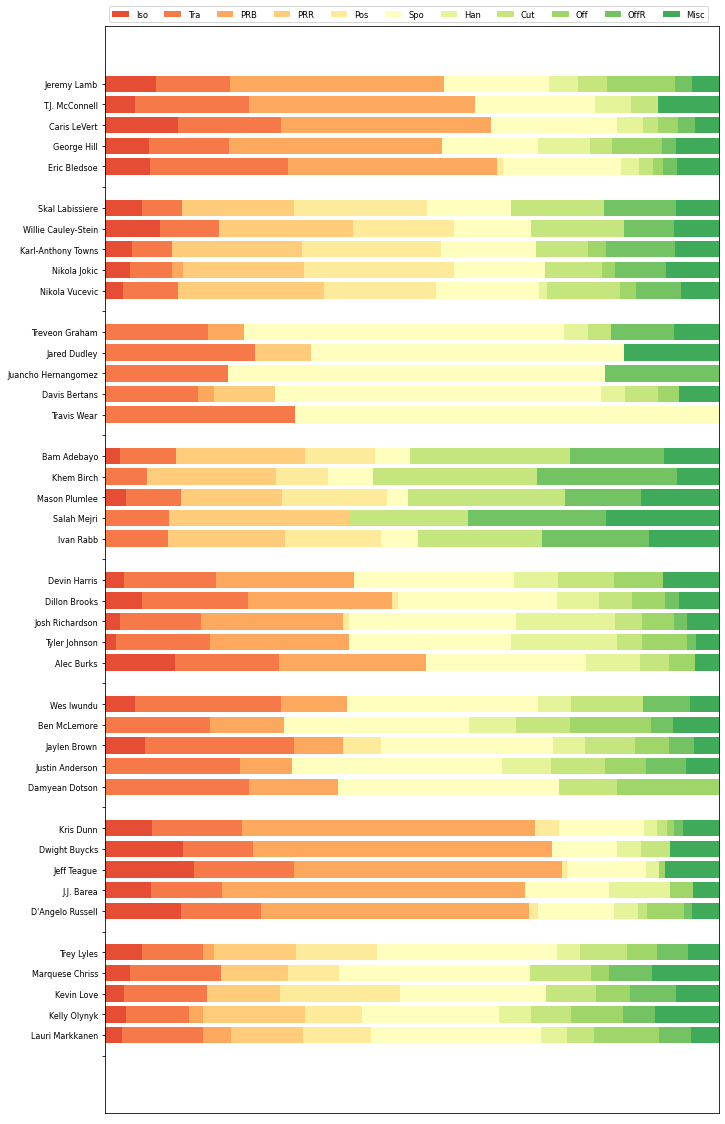

In [2]:
def pca_processing(fname, n_comp=3):
    '''
    Function to decrease the dimension of the players based on their POSS_PCT
    :param fname: the path of the pca_table file
    :param n_comp: the number of main components we want to use
    :return: data after pca with dimension n*n_comp; player names
    '''
    df = pd.read_csv(fname)
    kept_cols = [
        col for col in df.columns if col.endswith("freq")
    ]
    kept_cols.append("PLAYER_NAME")
    kept_cols.reverse()
    df = df[kept_cols]

    player_name = df["PLAYER_NAME"]
    data_org = df.iloc[:, 2:]
    pca = PCA(n_components=n_comp)
    pca.fit(data_org)
    data_pca = data_org @ pca.components_.T
    assert len(data_pca) == len(player_name)

    return data_pca, player_name


def k_means(fname, dim=3, cluster_num=5, show_img=False):
    '''
    Function to cluster the data into cluster_num groups and visualize them in a 3D space
    :param fname: the path of the pca_table file
    :param dim: the number of dimensions we want to use
    :param cluster_num: the number of clusters we want to cluster them
    :param show_img: show k-means image or not
    :return: NONE
    '''
    assert isinstance(fname, str)
    data, names = pca_processing(fname, dim)
    X = np.array(data)
    k_means = KMeans(n_clusters=cluster_num).fit(X)
    labels = k_means.labels_
    distance = k_means.transform(X)
    return names, labels, distance


def calculate_top5(distance, names):
    '''
    Function to find the top5 players who are the most closest to the k-means's cluster center
    :param distance: Distance of each player to the clusters
    :param names: names of each player
    :return: top5 names of each clusters
    '''
    dim = len(distance[0])
    result = np.zeros((dim, 5))
    top5_name = []
    for i in range(dim):
        temp = []
        curr = np.array(distance[:, i])
        min_5 = curr.argsort()[:5]
        result[i, :] = min_5
        for index in min_5:
            temp.append(names[index])
        top5_name.append(temp)
    return top5_name


def top5_img(distance, names, year):
    '''
    :param distance: distance of player to kmeans center
    :param names: player names
    :param year: year
    :return: dictionary of player names and their play type
    '''
    assert 2015 <= year <= 2019
    top5names = calculate_top5(distance, names)
    path = "data/data_cleaned/pca_data/" + str(year) + "_pca_table.csv"
    df = pd.read_csv(path)
    data_per_player = np.zeros((1, 11))
    for i in range(len(top5names)):
        for j in range(len(top5names[i])):
            new_df = df[df['PLAYER_NAME'] == top5names[i][j]]
            data = new_df[
                ["iso_freq", "tr_freq", "prb_freq", "prr_freq", "pu_freq", "su_freq", "ho_freq", "cut_freq", "os_freq",
                 "putback_freq", "misc_freq"]]
            data = data.values.tolist()
            data = np.array(data)[0]
            data_per_player = np.vstack((data_per_player, data))
    data_per_player = data_per_player[1:,:]
    data_per_player = data_per_player / data_per_player.sum(axis=1, keepdims=True)
    # print(data_per_player.shape)
    result = {}
    for i in range(8):
        for j in range(5):
            result[top5names[i][j]] = data_per_player[i * 5 + j, :]
    return result

def survey(results):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
        The category labels.
    """
    category_names = ["Iso",
                      "Tra",
                      "PRB",
                      "PRR",
                      "Pos",
                      "Spo",
                      "Han",
                      "Cut",
                      "Off",
                      "OffR",
                      "Misc"]

    labels = list(results.keys())
    new_labels = []
    start = " "
    for i in range(len(labels)):
        new_labels.append(labels[i])
        if i % 5 == 4:
            new_labels.append(start)
            start += " "
    labels = new_labels
    data = np.array(list(results.values()))
    new_data = []
    for i in range(len(data)):
        new_data.append(data[i])
        if i % 5 == 4:
            new_data.append(np.zeros(shape=data[0].shape))
    data = np.array(new_data)

    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(11,20))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.barh(labels, widths, left=starts, height=0.8,
                label=colname, color=color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


names, labels, distance = k_means('data/data_cleaned/pca_data/2017_pca_table.csv', 3, 8)
results = top5_img(distance, names, 2017)
survey(results)
plt.show()

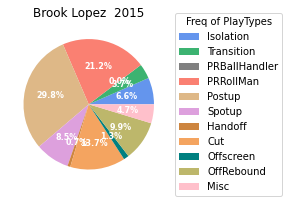

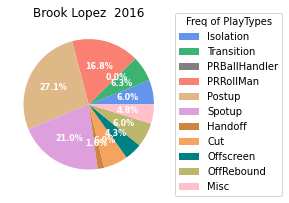

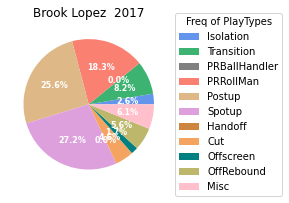

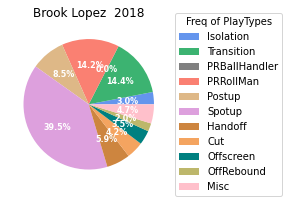

In [3]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)


def draw_pie_chart(name, year):
    '''
    Function to draw the pie chart of players of different PlayType.
    Just input the player name and the year you want to know.
    :param name: Player name, string
    :param year: year
    :return:
    '''
    assert isinstance(name, str)
    assert 2015 <= year <= 2019
    path = "data/data_cleaned/pca_data/" + str(year) + "_pca_table.csv"
    df = pd.read_csv(path)
    new_df = df[df['PLAYER_NAME'] == name]
    data = new_df[["iso_freq", "tr_freq", "prb_freq", "prr_freq", "pu_freq", "su_freq", "ho_freq", "cut_freq", "os_freq",
                  "putback_freq", "misc_freq"]]
    data = data.values.tolist()
    data = np.array(data)[0]
    data = data / np.sum(data)
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    recipe = ["Isolation",
              "Transition",
              "PRBallHandler",
              "PRRollMan",
              "Postup",
              "Spotup",
              "Handoff",
              "Cut",
              "Offscreen",
              "OffRebound",
              "Misc"]
    ingredients = [x.split()[-1] for x in recipe]
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), shadow=False,
                                      colors=["cornflowerblue", "mediumseagreen", "gray", "salmon", "burlywood", "plum",
                                              "peru", "sandybrown", "teal", "darkkhaki", "pink"])
    ax.legend(wedges, ingredients,
              title="Freq of PlayTypes",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title(name + "  " + str(year))

    plt.show()
    return

for i in range(2015, 2019):
    draw_pie_chart("Brook Lopez", i)

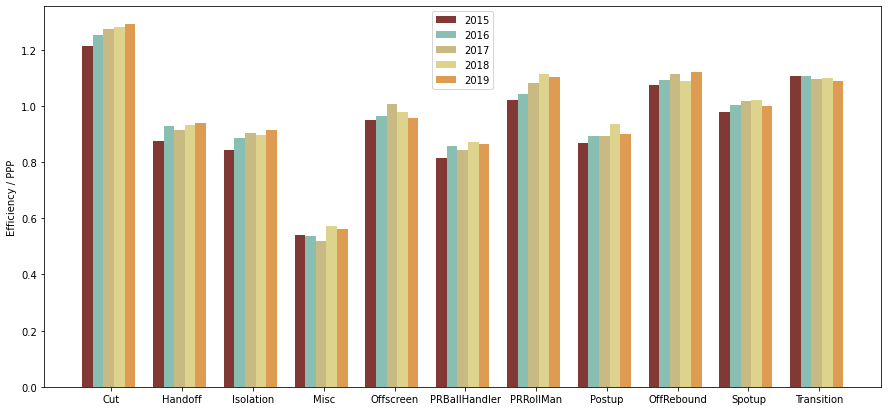

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.scraping.pull_nba import pull_nba
from src.scraping.json_to_DF import json_to_DF
from collections import defaultdict


playtypes = ['cut', 'ho', 'iso', 'misc',
             'os', 'prb', 'prr', 'pu',
             'putback', 'su', 'tr']

playtype_shortcut = {'iso':'Isolation', 'tr':'Transition', 'prb':'PRBallHandler', 
                     'prr':'PRRollMan','pu':'Postup','su': 'Spotup', 
                     'ho':'Handoff','cut':'Cut', 'os':'Offscreen', 
                     'putback':'OffRebound', 'misc':'Misc'}


def get_plot_data(aggr_data=None):
    """
    param: aggr_data, str, where the yearly aggregated data is
    param: outdir, str, folder to store output figures
    return: plot_data, dictionary = {year: data list of the year}
    """

    assert aggr_data, "Input directory is invalid."

    files = os.listdir(aggr_data)
    plot_data = defaultdict(list)
    for f in files:
        df = pd.read_csv(
            os.path.join(aggr_data, f)
        )
        year = "".join(
            [c for c in f if '0' <= c <= '9']
        )
        year = int(year)


        for col in playtypes:
            df[col + "_pts"] = df[col + "_ppp"] * df[col + "_poss"]
        df_sum = df.sum()
        for col in playtypes:
            plot_data[year].append(
                df_sum[col + "_pts"] / df_sum[col + "_poss"]
            )
    return plot_data


def plot_most_effi_figure(aggr_data, outdir=None):
    """
    param: aggr_data, str, where the yearly aggregated data is
    param: outdir, str, folder to store output figures
    return: save figures in the outdir
    """
    if outdir and not os.path.exists(outdir):
        os.mkdir(outdir)

    plot_data = get_plot_data(aggr_data)
    x = np.arange(11, dtype=np.float64)
    bar_width, start = 0.15, x
    colors = ["#823935", "#89BEB2", "#C9BA83", "#DED38C", "#DE9C53"]
    
    plt.figure(figsize=(15, 7))
    for year in range(2015, 2020):
        plt.bar(
            start, 
            plot_data[year], 
            bar_width, 
            color=colors[year-2015], 
            label=str(year)
        )
        start += bar_width

    plt.legend(loc="upper center")
    plt.xticks(
        x - 5.5 * bar_width / 2, [playtype_shortcut[x] for x in playtypes]
    )
    plt.ylabel("Efficiency / PPP")
    plt.show() 


plot_most_effi_figure("data/data_cleaned/poss_ppp_data")

In [5]:
"""

This part of plots can't be showed inline in .ipynb file.
Please refer to Readme.md for more information.

"""


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib; matplotlib.use("TkAgg")
from sklearn import cluster
#import plotly
import plotly.graph_objs as go
import chart_studio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py

def scatter_plot_in(fname):
    '''
    Function that outputs total poss, ppp, and name of each player through 3 lists
    fname is expected directory path
    fname must use data in ./poss_ppp_data

    '''
    pt_abrv = ['iso','tr','prb','prr','pu','su','ho','cut','os','putback','misc']

    fname= "data/data_cleaned"+ fname
    
    df = pd.read_csv(fname)

    df_calc = pd.DataFrame()
    for i in pt_abrv:
        df_poss = df[i+'_poss']
        df_ppp = df[i+'_ppp']
    
        df_points = df_ppp * df_poss
        df_calc[i+'_points'] = df_points

    ppp = df_calc.sum(axis=1) / df['total_poss']
    return df['total_poss'].tolist(), ppp.tolist(), df['PLAYER_NAME'].tolist() 

chart_studio.tools.set_credentials_file(username='swishan', api_key='nQfq97kmHYvg1HhlKSp5')

flist=['/poss_ppp_data/poss2015.csv','/poss_ppp_data/poss2016.csv','/poss_ppp_data/poss2017.csv','/poss_ppp_data/poss2018.csv','/poss_ppp_data/poss2019.csv']
def create_slider_scatter(fname_list, title_graph, yaxis_label, x_axis_label):
	"""
	get xy should take in the list of filenames for each year and output the x values, i.e. total possessions for the year vs total PPP.
	PPP should be weighted according to the number of possessions right, like a players season PPP, is PPP_i * Poss_i, where i is the playtype
	"""
	fig = go.Figure()
	colorscale_curr=[[0.0, "rgb(165,0,38)"],[0.1111111111111111, "rgb(215,48,39)"],[0.2222222222222222, "rgb(244,109,67)"],[0.3333333333333333, "rgb(253,174,97)"],[0.4444444444444444, "rgb(254,224,144)"],[0.5555555555555556, "rgb(224,243,248)"],[0.6666666666666666, "rgb(171,217,233)"],[0.7777777777777778, "rgb(116,173,209)"],[0.8888888888888888, "rgb(69,117,180)"],[1.0, "rgb(49,54,149)"]]
	colorscale_curr.reverse()

	#just going to use global variable list of path strings; 
	for i in range(len(flist)):
		x_1, y_1, names = scatter_plot_in(flist[i])

		fig.add_trace(
		go.Scatter(x=x_1, y= y_1, text = names, hoverinfo = 'text', mode='markers', marker=dict(color=y_1 , colorscale=colorscale_curr, size=12, line=dict(width=2, color ='DarkSlateGrey')), visible=False, name="Points Per Possession vs Possessions " + str(i)
		))
	fig.data[0].visible = True

	steps = []
	for i in range(len(fig.data)):
	    step = dict(
	        method="restyle",
	        args=["visible", [False] * len(fig.data)],
	        label='Year ' + str(i + 2015)

	    )
	    step["args"][1][i] = True  # Toggle i'th trace to "visible"
	    steps.append(step)


	#plotly.offline.plot(data, filename='Clusters_9.html')

	sliders = [dict(
	    active=5,
	    currentvalue={"prefix": "Year: "},
	    pad={"t": 5},
	    steps=steps
	)]
	start_index = 2015
	fig.update_layout(
	    sliders=sliders,
	    #title = "9 Cluster classification of players based on Scoring Styles"
	    title={"text": title_graph},
	    xaxis_title=x_axis_label,
    	yaxis_title=yaxis_label,
	)

	fig.show()
	py.iplot(fig,sharing='public',filename=title_graph)
	#plotly.offline.plot(fig, filename=title_graph+".html")

	return "Completed"
print(create_slider_scatter(['2015','2016','2019','2020'], 'Points Per Possession vs Possessions', 'PPP', 'Possessions'))


ModuleNotFoundError: No module named '_plotly_utils.utils'

In [2]:
"""

This part of plots can't be showed inline in .ipynb file.
Please refer to Readme.md for more information.

"""

#Visualization
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib; matplotlib.use("TkAgg")
from sklearn import cluster
import plotly
import plotly.graph_objects as go
from sklearn.metrics import silhouette_samples, silhouette_score
import chart_studio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py



chart_studio.tools.set_credentials_file(username='swishan', api_key='nQfq97kmHYvg1HhlKSp5')



def pca_processing(fname, n_comp=3):
    '''
    Function to decrease the dimension of the players based on their POSS_PCT
    :param fname: the path of the pca_table file
    :param n_comp: the number of main components we want to use
    :return: data after pca with dimension n*n_comp; player names
    '''
    df = pd.read_csv(fname)
    kept_cols = [
        col for col in df.columns if col.endswith("freq")
    ]
    kept_cols.append("PLAYER_NAME")
    kept_cols.reverse()
    df = df[kept_cols]

    player_name = df["PLAYER_NAME"]
    data_org = df.iloc[:, 2:]
    pca = PCA(n_components=n_comp)
    pca.fit(data_org)
    data_pca = data_org @ pca.components_.T
    assert len(data_pca) == len(player_name)
    # fig, ax = plt.subplots()
    # for i in range(int(data_pca.size/2)):
    #     player = data_pca[i]
    #     ax.scatter(player[0], player[1])
    # plt.show()

    return data_pca, player_name


def k_means(fname, dim=3, cluster_num=5):
    '''
    Function to cluster the data into cluster_num groups and visualize them in a 3D space
    :param fname: the path of the pca_table file
    :param dim: the number of dimensions we want to use
    :param cluster_num: the number of clusters we want to cluster them
    :return: NONE
    '''
    assert isinstance(fname, str)
    data, names = pca_processing(fname, dim)
    X = np.array(data)
    k_means = KMeans(n_clusters=cluster_num).fit(X)
    labels = k_means.labels_



    return names, X, labels

def get_silscores(fname, dim=3):
    best=0
    final_clus=0
    for cluster_num in range(5,9):
        data, names = pca_processing(fname, dim)
        X = np.array(data)
        k_means = KMeans(n_clusters=cluster_num).fit(X)
        labels = k_means.labels_
        silhouette_avg = silhouette_score(X, labels)
        if silhouette_avg >= best:
            best = silhouette_avg
            final_clus= cluster_num

    return best, final_clus

# final_list=['2015','2016','2017','2018','2019']
# for each in final_list:
#     print(each)
#     print(get_silscores('aggr_data/'+each+'_pca_table.csv', dim=3))

######################
# data = [plotly.graph_objs.Scatter3d(x=X[:, 1], y=X[:, 0], z=X[:, 2], text = names, hoverinfo = 'text', mode='markers', marker=dict(color=labels))]
fig = go.Figure()
final_list=['2015','2016','2017','2018','2019']
dims = [5, 6, 7, 8, 8]
count =0 

for each in final_list:

	names, X, labels = k_means('data/data_cleaned/pca_data/'+each+'_pca_table.csv', dim=3, cluster_num=dims[count])
	count+=1
	fig.add_trace(
	go.Scatter3d(x=X[:, 1], y=X[:, 0], z=X[:, 2], text = names, hoverinfo = 'text', mode='markers', marker=dict(color=labels), visible=False, name="Player Clusters for " + each)
	)

#print(len(fig.data))
fig.data[0].visible = True

steps = []
for i in range(len(fig.data)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
        label='Year ' + str(i + 2015)

    )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)


#plotly.offline.plot(data, filename='Clusters_9.html')

sliders = [dict(
    active=5,
    currentvalue={"prefix": "Year: "},
    pad={"t": 5},
    steps=steps
)]
start_index = 2015
fig.update_layout(
    sliders=sliders,
    #title = "9 Cluster classification of players based on Scoring Styles"
    title={"text": "Scoring Clusters Per Year"}
)

#fig.show()
py.iplot(fig,sharing='public',filename='Clusters_final')
#k_means('aggr_data/2015_pca_table.csv', 3, 9)




PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, 'https://plotly.com/~swishan/27/', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.